In [16]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [17]:
import os

from google.colab import drive
drive.mount('/content/drive')


In [18]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image



In [19]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}



In [21]:
# Load the Data

# Set train and valid directory paths

dataset = 'output/'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = 2
print('Number of classes is: ', num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)


Number of classes is:  2
{0: 'human', 1: 'no_human'}


In [22]:
train_data_size, valid_data_size, test_data_size


(67641, 799, 800)

In [23]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to('cuda:0')


In [24]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False


In [25]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # num_classes is number of outputs, ex use 2 for binary
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cuda:0')


In [26]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [27]:
def train_and_validate(model, loss_criterion, optimizer, epochs):
    '''
    Function to train and validate
    Parameters
        param model: Model to train and validate
        param loss_criterion: Loss Criterion to minimize
        param optimizer: Optimizer for computing gradients
        param epochs: Number of epochs
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dictionary object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 180 epochs
num_epochs = 180
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/180
Epoch : 000, Training: Loss: 0.3300, Accuracy: 85.4216%, 
		Validation : Loss : 0.2385, Accuracy: 90.3630%, Time: 238.5985s
Epoch: 2/180
Epoch : 001, Training: Loss: 0.2655, Accuracy: 88.7834%, 
		Validation : Loss : 0.1969, Accuracy: 91.6145%, Time: 240.2526s
Epoch: 3/180
Epoch : 002, Training: Loss: 0.2472, Accuracy: 89.6202%, 
		Validation : Loss : 0.1947, Accuracy: 92.1151%, Time: 240.4999s
Epoch: 4/180
Epoch : 003, Training: Loss: 0.2376, Accuracy: 90.0785%, 
		Validation : Loss : 0.2102, Accuracy: 92.2403%, Time: 240.9451s
Epoch: 5/180
Epoch : 004, Training: Loss: 0.2232, Accuracy: 90.7453%, 
		Validation : Loss : 0.2184, Accuracy: 91.3642%, Time: 240.3978s
Epoch: 6/180
Epoch : 005, Training: Loss: 0.2154, Accuracy: 90.9981%, 
		Validation : Loss : 0.1730, Accuracy: 92.3655%, Time: 240.4025s
Epoch: 7/180
Epoch : 006, Training: Loss: 0.2119, Accuracy: 91.3337%, 
		Validation : Loss : 0.1982, Accuracy: 92.3655%, Time: 240.6998s
Epoch: 8/180
Epoch : 007, Training: Loss:

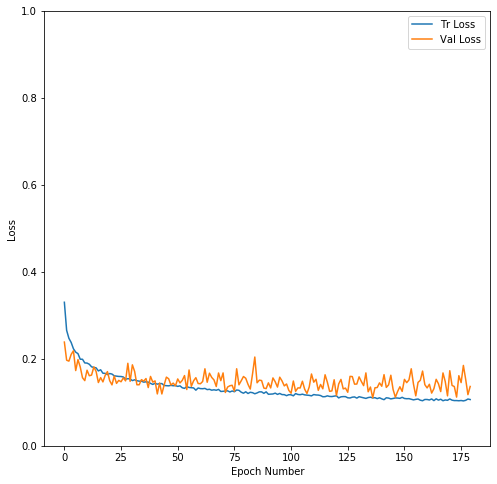

In [30]:
from matplotlib import pyplot as plt

history = np.array(history)

plt.figure(figsize=(8,8))
plt.plot(history[:,0:2]) 
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


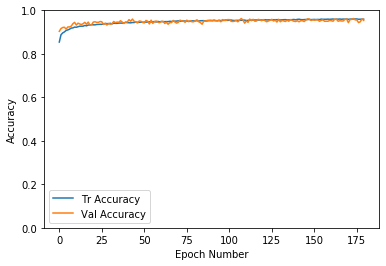

In [32]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [33]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        param model: Model to test
        param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
           # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

    

In [34]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        param model: Model to test
        param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        print(ps)
        topk, topclass = ps.topk(1, dim=1)
        print(topk)
        print(topclass)
        #for i in range(2):
        print("Prediction", topclass.cpu().numpy()[0][0], ":", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][0])
        return topclass.cpu().numpy()[0][0]
        

tensor([[1.9316e-05, 9.9998e-01]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')
tensor([[1]], device='cuda:0')
Prediction 1 : no_human , Score:  0.9999809


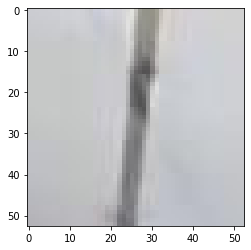

In [36]:
result = predict(trained_model, '/home/team4/output/test/no_human/10-10-2018 Panama City, Fl Hurricane Michael, flying drone through school, buildings collapsed_580._sample_1421_x723_y424.jpg')

In [38]:
computeTestSetAccuracy(trained_model,loss_func)

Test Batch number: 000, Test: Loss: 0.0994, Accuracy: 0.9688
Test Batch number: 001, Test: Loss: 0.0868, Accuracy: 0.9375
Test Batch number: 002, Test: Loss: 0.0359, Accuracy: 0.9688
Test Batch number: 003, Test: Loss: 0.1790, Accuracy: 0.9062
Test Batch number: 004, Test: Loss: 0.3078, Accuracy: 0.9375
Test Batch number: 005, Test: Loss: 0.1736, Accuracy: 0.9375
Test Batch number: 006, Test: Loss: 0.2850, Accuracy: 0.9062
Test Batch number: 007, Test: Loss: 0.0218, Accuracy: 1.0000
Test Batch number: 008, Test: Loss: 0.1512, Accuracy: 0.9375
Test Batch number: 009, Test: Loss: 0.0527, Accuracy: 1.0000
Test Batch number: 010, Test: Loss: 0.1416, Accuracy: 0.9688
Test Batch number: 011, Test: Loss: 0.0833, Accuracy: 0.9688
Test Batch number: 012, Test: Loss: 0.1213, Accuracy: 0.9375
Test Batch number: 013, Test: Loss: 0.0303, Accuracy: 1.0000
Test Batch number: 014, Test: Loss: 0.0669, Accuracy: 0.9688
Test Batch number: 015, Test: Loss: 0.0792, Accuracy: 0.9688
Test Batch number: 016, 

In [40]:
#Covert the torch model to cpu model
model_cpu=trained_model.cpu()

In [41]:
torch.save(model_cpu, dataset+'_newmodel_cpu'+'.h5')